## Finding Arduino Ports
When working with Arduino, it's essential to know which port your Arduino board is connected to on your computer. This is necessary for uploading code and communicating with the board. Each port is identified by a unique name or number, depending on the operating system:

- On Windows, ports are named like `COM3`, `COM4`, etc.
- On macOS and Linux, ports are named like `/dev/ttyUSB0`, `/dev/ttyACM0`, etc.

Run the next cell to know the port number.


In [170]:
import serial.tools.list_ports

def list_all_ports():
    ports = serial.tools.list_ports.comports()

    if not ports:
        print("No serial ports found.")
    else:
        print("Available serial ports:")
        for port in ports:
            print(f"Port: {port.device}, Description: {port.description}")

list_all_ports()

Available serial ports:
Port: /dev/cu.debug-console, Description: n/a
Port: /dev/cu.Bluetooth-Incoming-Port, Description: n/a
Port: /dev/cu.usbmodem1301, Description: Nano 33 BLE
Port: /dev/cu.usbmodem1401, Description: Nano 33 BLE


#### Setup the serial communication with arduino

Change the port value in the next cell with the result that you got in the previous cell

In [ ]:
import serial
import time

port = '/dev/cu.usbmodem1301' 
baudrate = 115200
duration = 20

import serial

def read_serial_and_save(file_path):
    with serial.Serial(port, baudrate) as arduino, open(file_path, 'w') as file:
        arduino.timeout = 1  # Set timeout for serial read
        end_time = time.time() + duration  # Run for 'duration' seconds
        while time.time() < end_time:
            if arduino.in_waiting > 0:
                data = arduino.readline().decode().strip()
                file.write(data + '\n')
                print(data)

if __name__ == "__main__":
    save_path = "received_raw_data.txt"
    read_serial_and_save(save_path)


Start Sample: 3772
Stop Sample: 7573
Total signal time: 3801 mS


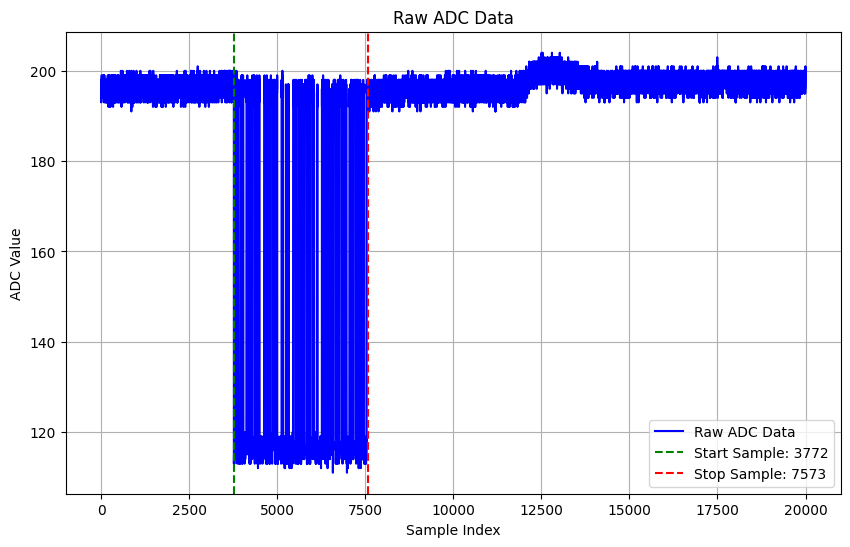

In [202]:
import numpy as np
import matplotlib.pyplot as plt

def load_signal(filename):
    with open(filename, 'r') as f:
        signal = [float(line.strip()) for line in f]
    return np.array(signal)

def find_start(file_path, baseline_samples=2000, noise_factor=5):
    # Load the signal from the file
    with open(file_path, 'r') as file:
        signal = np.array([float(line.strip()) for line in file])

    # Calculate baseline noise margin
    baseline = signal[:baseline_samples]
    mean_baseline = np.mean(baseline)
    std_baseline = np.std(baseline)
    noise_margin_upper = mean_baseline + noise_factor * std_baseline
    noise_margin_lower = mean_baseline - noise_factor * std_baseline

    # Find start sample
    start_sample = None
    for i in range(baseline_samples, len(signal)):
        if signal[i] < noise_margin_lower or signal[i] > noise_margin_upper:
            start_sample = i
            break

    return start_sample

def detect_stop_auto(signal, window_size=200, min_constant_samples=2000):
    smoothed_signal = smooth_signal(signal, window_size)
    
    # Calculate a dynamic baseline and noise level
    baseline = np.mean(smoothed_signal[:min_constant_samples])  # Initial baseline
    noise_level = np.std(smoothed_signal[:min_constant_samples])  # Initial noise level
    
    start_dummy_sample = None
    stop_sample = None
    constant_count = 0

    for i in range(len(smoothed_signal)):
        deviation = abs(smoothed_signal[i] - baseline)
        
        # Determine if a significant change occurs
        if deviation > 2 * noise_level:  # Threshold = 3 * noise level (common heuristic)
            if constant_count >= min_constant_samples and start_dummy_sample is None:
                start_dummy_sample = i - constant_count
            constant_count = 0
        else:
            constant_count += 1
        
        # Update the stop sample if signal stabilizes
        if constant_count >= min_constant_samples and start_dummy_sample is not None:
            stop_sample = i - constant_count
            break  # Remove this to continue detecting multiple patterns

    return stop_sample

def smooth_signal(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')


filename = 'received_raw_data.txt'  # Replace with your file name
raw_signal = load_signal(filename)

# Detect start and stop samples automatically
start = find_start(filename)
stop = detect_stop_auto(raw_signal, window_size=200, min_constant_samples=2000)

print("Start Sample:", start)
print("Stop Sample:", stop if stop is not None else "No stop pattern detected")
total_run_time = stop-start
print("Total signal time:", total_run_time, end =" ")
print("mS")

plt.figure(figsize=(10, 6))
plt.plot(raw_signal, label="Raw ADC Data", color='blue', linestyle='-')
plt.axvline(x=start, color='g', linestyle='--', label=f"Start Sample: {start}")
plt.axvline(x=stop, color='r', linestyle='--', label=f"Stop Sample: {stop}")
plt.xlabel("Sample Index")
plt.ylabel("ADC Value")
plt.title("Raw ADC Data")
plt.legend()
plt.grid(True)
plt.show()

In [207]:
def count_matching_characters(file1_path, file2_path):
    try:
        with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
            words1 = file1.read().split()  # Split content into words
            words2 = file2.read().split()
        
        match_count = 0
        
        for word1, word2 in zip(words1, words2):
            for char1, char2 in zip(word1, word2):
                if char1 == char2:
                    match_count += 1

        return match_count
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return 0
    


# Input file paths
message_file_path = 'message_small.txt'  # Replace with your first file path
decoded_message_path = 'test.txt'  # Replace with your second file path

with open(message_file_path, 'r') as file:
    line = file.readline().strip() 
total_count = len(line)

matching_characters = count_matching_characters(message_file_path, decoded_message_path)

print(f"Number of bits in the input message: {total_count}")
print(f"Number of matching bits: {matching_characters}")

Number of bits in the input message: 184
Number of matching bits: 183
